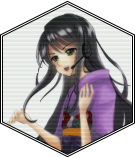

In [2]:
from IPython.display import Image, display
Image("ryoko.png", width="70")

# Message from Dr. Ryoko
"*Hi! I hope you now understand how the Lights Out puzzle works.<br/>The floor of the room I must cross has 3 x 3 tiles. Each tile is made of a single qubit.<br/>
Some of these qubits fluctuate between the ground state and the excited state. <br/> I have been observing their behavior and noticed that there is a pattern - the floor can only be in either one of the four patterns as shown in each of the examples below. <br/>
Due to decoherence, there is not enough time to play around with the switches.<br/> You need to find out which board can be cleared with three switch operations. Good luck!*"<br/>

# Week2-B: Four-Lights Out
In this problem, we are dealing with multiple binary data at the same time. 
We have to determine if each of the given four Lights Out boards are solvable under the given constraints, so let's devise a quantum circuit to solve them all at the same time.

As an example, let's consider how to find a board that can be cleared with just a single switch operation from the 4 boards given below. The initial state of the 4 boards is given in the following two-dimensional array, where "0" and "1" represent "off" and "on" respectively similar to the previous learning problem:

lightsout4_ex=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\]

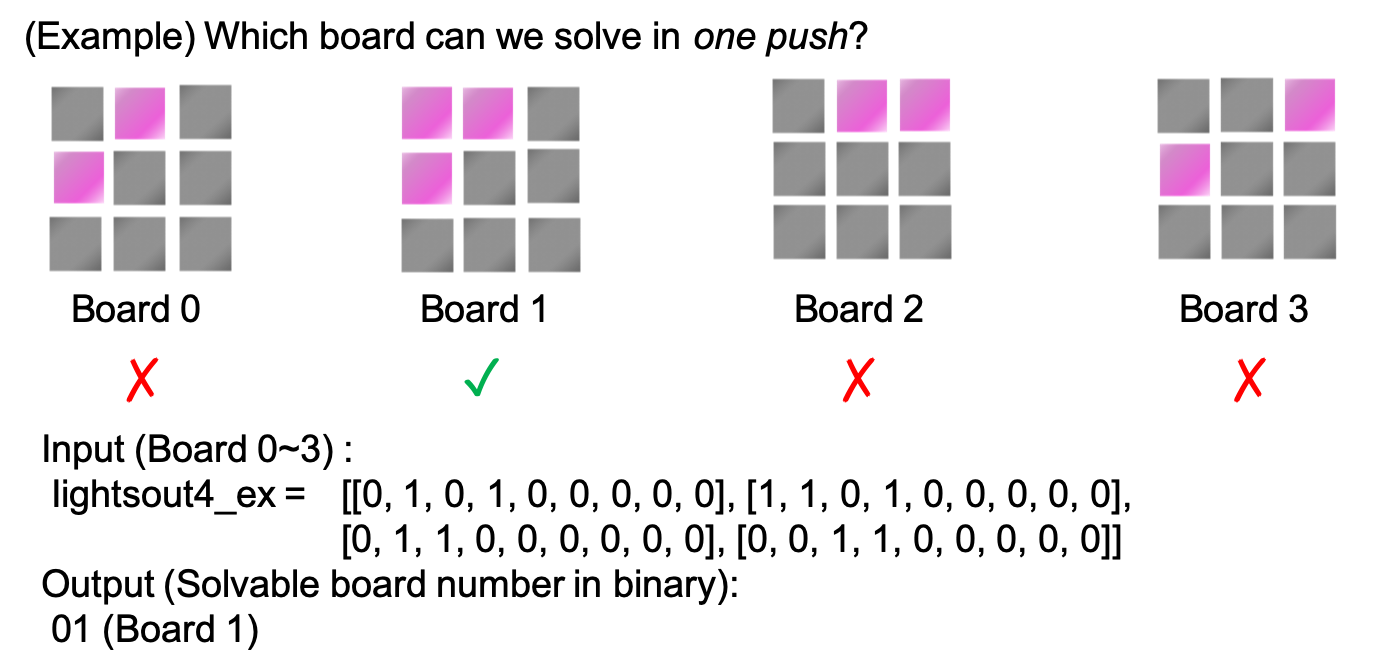

In [6]:
from IPython.display import Image, display
Image('4lightsout_ex.png')

1回のON/OFFで解けるのはどのBoardか、という例題

## Answer Strategy
If only one board is given, this is a decision problem.
Using the algorithm from the first Lights Out puzzle (2A), you can solve this problem by counting the "1"s in the output.
 
If we are given multiple boards, there will be several approaches.
1. Iterate the same "one board algorithm" for each board.
2. Hold information for multiple boards at the same time and solve the problems in a single run (execute the algorithm once). 
- For the rest of this document, we discuss how to use the latter approach to solve this type of problem.

First, how do we keep data for all the boards at the same time?
1. Naive data structures:　　9 Qubits/board * 4 boards > 32 qubits (Upper limit of ibm_qasm_simulator).
2. Prepare the  superposition state:   $\vert Board 0\rangle + \vert Board 1\rangle + \vert Board 2\rangle + \vert Board 3\rangle$.
    - The circuit configuration used for state generation is non-trivial.
3. *qRAM* is known as one solution. 
    - **Pros**: Intuitive implementation. 
    - **Cons**: Computationally expensive. 

Of course you can devise and adopt other smart ways to do this.

Here, we will focus on *qRAM* and describe its configuration and implementation.

In [2]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-12-13 18:14:38,629: Credentials are already in use. The existing account in the session will be replaced.


## qRAM: Quantum Random Access Memory

In classical computers, RAM (Random Access Memory) is a type of volatile memory that has memory addresses $j$ and stores binary data corresponding to each address $D_j$.

In the case of [qRAM](https://arxiv.org/abs/0708.1879) in a quantum computer, **address qubits $a$** have the $N$-addresses as superposition and the corresponding binary data is stored in **data qubits $d$** as a state vector.
\\[
\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\\]　　
We call the right-hand side state "qRAM" and the corresponding gate operation "qRAM operation".

Although qRAM operation requires $\mathcal{O}(N\log N)$ gates, it can be used to create superposition states of binary data intuitively.  

qRAM has previously been applied to various quantum machine learning algorithms such as the HHL algorithm. For this problem, let's apply qRAM to Grover's algorithm.

qRAMはアドレスビットに対して、値であったり問題の埋め込みなどを対応させることです。  
今回の課題では入力や最終的な出力がアドレスビットであり、実際の問題はすべてancillaを使って実装します。  

## Example: Find the data from qRAM
Prepare a qRAM of $n$-addresses in which the numbers $k_0, k_1, .. , k_{n-1}$ are stored in this order.  
Find the address in which the number $m$ is stored using Grover's algorithm.  
- $n = 4$
- $k = [1,2,5,7]$
- $m = 7$

### qRAM operation.
Here we show a circuit example of qRAM.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


{'00001': 2008, '10101': 2039, '11111': 1964, '01010': 1989}


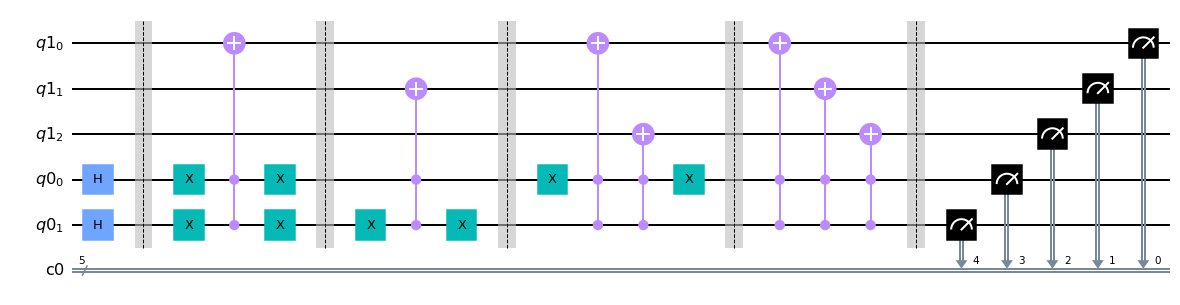

In [2]:
address = QuantumRegister(2)
data = QuantumRegister(3)
c = ClassicalRegister(5)
qc = QuantumCircuit(address,data,c)

# address preparation
qc.h([address[0],address[1]])
qc.barrier()
# address 0 -> data = 1
qc.x([address[0],address[1]])
qc.ccx(address[0],address[1],data[2])
qc.x([address[0],address[1]])
qc.barrier()
# address 1 -> data = 2
qc.x(address[0])
qc.ccx(address[0],address[1],data[1])
qc.x(address[0])
qc.barrier()
# address 2 -> data = 5
qc.x(address[1])
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[0])
qc.x(address[1])
qc.barrier()
# address 3 -> data = 7
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[1])
qc.ccx(address[0],address[1],data[0])
qc.barrier()


#Check the qRAM　status
qc.measure(address[0:2], c[0:2])
qc.measure(data[0:3], c[2:5])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

qc.draw(output='mpl')

### qRAM Data Search
To perform Grover's algorithm, we invert the sign of the **address qubit** containing $m$. We also need to initialize the **data qubit** by another qRAM operation before the Diffusion operation,

\begin{align*}
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f}
\xrightarrow{oracle}  
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j} = m\\
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j}  \neq m
 \end{array}
 \right.
 \xrightarrow{qRAM}
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},  D_{j} = m \\
\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},　D_{j}\neq m
 \end{array}
 \right.
 \end{align*}
 
where $f$ denotes the flag qubit.  

In this case, we can configure an oracle operation using the [C3X gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.C3XGate.html#qiskit.circuit.library.C3XGate) . 

Here, we show the whole circuit for our [qRAM example](#qRAM-Example:-Find-the-data-from-qRAM).

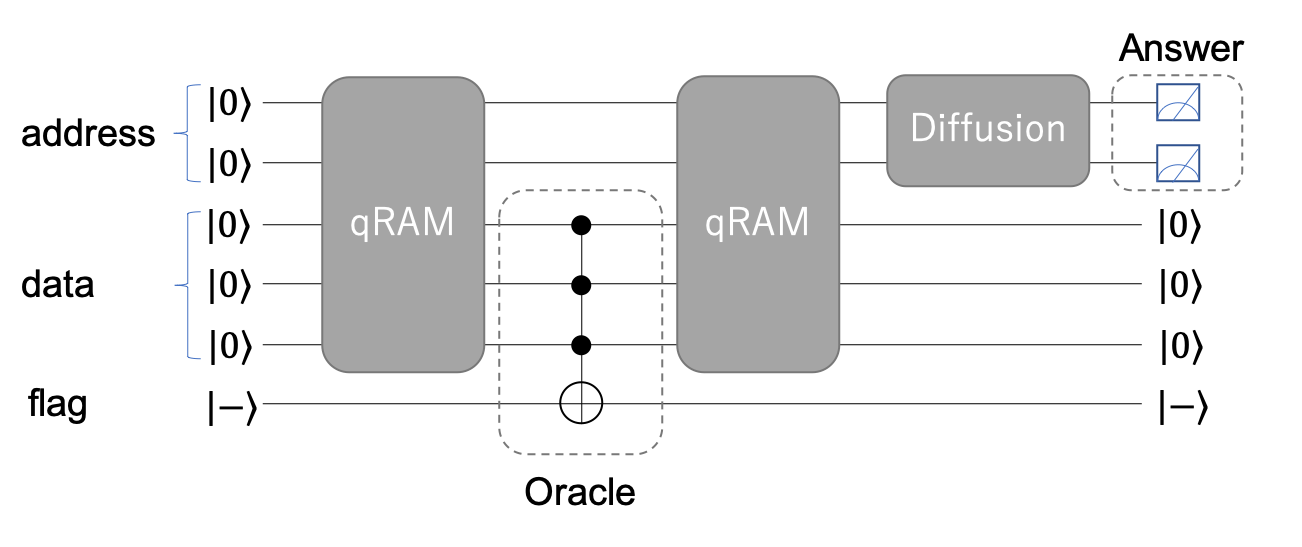

In [3]:
Image('circuit_ex.png')

### Considerations for qRAM implementation
In the above description we have introduced a naive *qRAM operation* circuit.
Depending on the data structure, we can simplify the circuit by using **gate synthesis** (equivalence transformation) techniques.
Also, some simplified gates, e.g. [RCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RCCXGate.html#qiskit.circuit.library.RCCXGate), may help improve your *CNOT*-saving implementation.

An example of gate synthesis is shown below.

これは問題が解けた上で、量子回路のコストを減らすための工夫です。  
例えば下記のように量子回路をよりゲートの少ない回路に置き換えることができます。

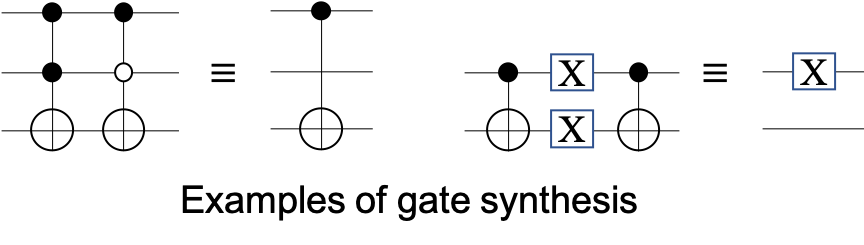

In [4]:
Image('gatesynthesis_ex.png')

## Learning Exercise II-B
Let's solve a 4-Lights Out problem with qRAM.  

When the initial board state lightsout4=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\] is described by the following data, 
determine the _binary_ number of the solvable boards in $3$ switch operations.  (ex. Board 0 → 00, 1 → 01, 2 → 10, 3 → 11)

Answer by creating a quantum circuit to solve the puzzle shown in the figure below. In the quantum circuit to be submitted, measure only the `solution` (2bit) that solves the puzzle.

To submit your solution, create a function which takes "lightsout4" as an input and returns `QuantumCircuit`.  You can choose a function name you like. Make sure it works even if you input another dataset to "lightsout4".

 **In addition, please implement the quantum circuit within 28 qubits.**

Please note that you can get the answer with the same endian as the one used in the description. You can also use the following function.
```python
qc = qc.reverse_bits()
```

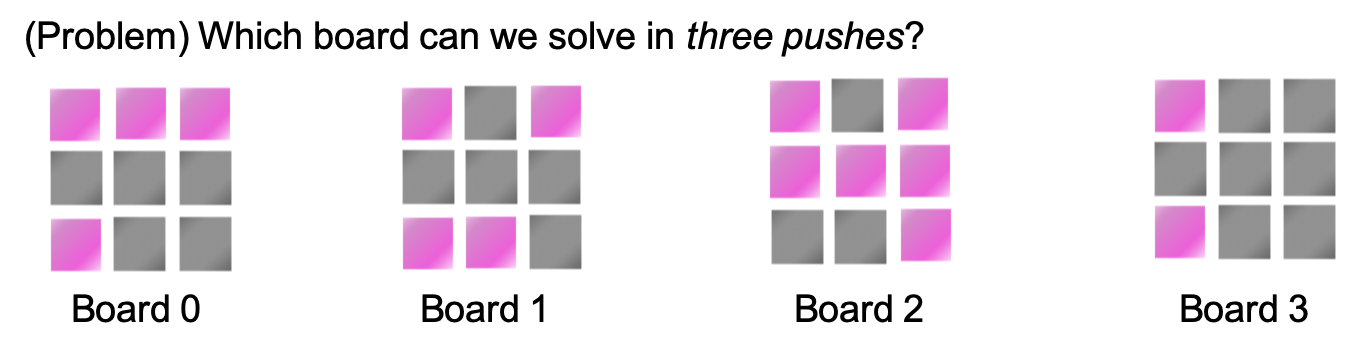

In [5]:
Image('4lightsout_pr.png')

In [3]:
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]

### Hints
- Change the oracle of [qRAM data search](#qRAM-Data-search) to an appropriate one.
- Data storing/writing in *QRAM operation* can be performed in any order. We can reduce the number of gates by taking into account the _hamming distance_ of the address and input data.

今回の課題では4面の重ね合わせ状態が問題として与えられ、その中で一つだけpush回数が3回でできるものがあるからその面の番号を当てよ、というものです。  
下記のような方針で進めます。
- それぞれ個別に解いた場合の答えを知り、3回のpushで解ける面番号をまず知っておく
- 問題をqRAMで埋め込む
- それぞれ解いた結果のうち、pushしたマスの数が3個である面番号(アドレスビットの状態)だけを増幅するようなOracleを作成する

---

## それぞれ個別に解いてみる

Week2Aの解答を利用してそのまま解いてみます。

In [3]:
def week2a_ans_func(lights):
    lights_key = str(lights)[1:-1].replace(', ', '')

    num_lights = len(lights)

    answer = QuantumRegister(num_lights)
    lighting = QuantumRegister(num_lights)
    oracle = QuantumRegister(1)
    cr = ClassicalRegister(num_lights)
    qc = QuantumCircuit(answer, lighting, oracle, cr)

    # Initialization
    qc.h(answer)
    qc.barrier()

    # oracle_9q
    for idx, light in enumerate(lights_key):
        if light == '0':
            qc.x(lighting[idx])
    qc.x(oracle)
    qc.h(oracle)

    qc.cx(answer[0], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[3], lighting[0])
    qc.barrier()

    qc.cx(answer[0], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[4], lighting[1])
    qc.barrier()

    qc.cx(answer[1], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[5], lighting[2])
    qc.barrier()

    qc.cx(answer[0], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[6], lighting[3])
    qc.barrier()

    qc.cx(answer[1], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[7], lighting[4])
    qc.barrier()

    qc.cx(answer[2], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[8], lighting[5])
    qc.barrier()

    qc.cx(answer[3], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[7], lighting[6])
    qc.barrier()

    qc.cx(answer[4], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[8], lighting[7])
    qc.barrier()

    qc.cx(answer[5], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[8], lighting[8])
    qc.barrier()

    qc.mct(lighting, oracle[0], mode='noancilla') 

    qc.cx(answer[5], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[8], lighting[8])
    qc.barrier()

    qc.cx(answer[4], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[8], lighting[7])
    qc.barrier()

    qc.cx(answer[3], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[7], lighting[6])
    qc.barrier()

    qc.cx(answer[2], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[8], lighting[5])
    qc.barrier()

    qc.cx(answer[1], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[7], lighting[4])
    qc.barrier()

    qc.cx(answer[0], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[6], lighting[3])
    qc.barrier()

    qc.cx(answer[1], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[5], lighting[2])
    qc.barrier()

    qc.cx(answer[0], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[4], lighting[1])
    qc.barrier()

    qc.cx(answer[0], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[3], lighting[0])
    qc.barrier()

    for idx, light in enumerate(lights_key):
        if light == '0':
            qc.x(lighting[idx])
    qc.barrier()

    # diffusion_9q
    qc.h(answer)
    qc.x(answer)
    qc.h(answer[num_lights - 1])
    qc.mct(answer[0:num_lights - 1], answer[num_lights - 1], mode='noancilla')
    qc.h(answer[num_lights - 1])
    qc.x(answer)
    qc.h(answer)

    qc.h(oracle)
    qc.x(oracle)
    qc.measure(answer, cr)

    # Change the endian 
    qc = qc.reverse_bits() 

    return qc

In [7]:
import pandas as pd

### 0(00)番の面

In [11]:
qc = week2a_ans_func(lightsout4[0])
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

110110111    21
111000001     8
000101000     6
011000101     6
111100011     6
             ..
000001101     1
001110001     1
000001100     1
001111010     1
110100001     1
Length: 439, dtype: int64


### 1(01)番の面

In [12]:
qc = week2a_ans_func(lightsout4[1])
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

001110000    15
111000001     8
111100011     6
100110010     6
110000000     6
             ..
011100111     1
001111000     1
110000010     1
111001110     1
110011001     1
Length: 440, dtype: int64


### 2(10)番の面

In [13]:
qc = week2a_ans_func(lightsout4[2])
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

100011111    15
111000001     8
000101000     6
011000101     6
110000000     6
             ..
001011010     1
111001110     1
110000010     1
000110100     1
110011001     1
Length: 440, dtype: int64


### 3(11)番の面

In [14]:
qc = week2a_ans_func(lightsout4[3])
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

011000011    20
111000001     8
100110010     6
000101000     6
110000000     6
             ..
011001110     1
110101111     1
100101111     1
100110100     1
101100110     1
Length: 440, dtype: int64


ということで、3回のpushで解ける面は1(01)番の面であることはわかりました。  
(なお、それぞれの正解状態は人間が手で解いた正解とちゃんといっちしています。)  
これを足掛かりに、この正解を得られるように回路を作りこんでいきます。

---

## qRAMを作成して面番号と答えを紐づける
アドレスビットの状態(00 ~ 11)に応じて面の初期状態にXゲートを掛けるようにします。  
つまり、面番号に応じてCCXを掛けます。

In [4]:
def solve_board(num_board):
    lights = lightsout4[num_board]
    lights_key = str(lights)[1:-1].replace(', ', '')

    num_lights = len(lights)

    board = QuantumRegister(2, 'board')
    switch = QuantumRegister(1, 'switch')
    answer = QuantumRegister(num_lights, 'answer')
    lighting = QuantumRegister(num_lights, 'lighting')
    oracle = QuantumRegister(1, 'oracle')
    cr = ClassicalRegister(num_lights)
    qc = QuantumCircuit(board, switch, answer, lighting, oracle, cr)

    # Initialization
    if num_board == 0:
        pass
    qc.x(switch)
    qc.h(answer)
    qc.barrier()

    qc.cx(board[1], switch[0])
    qc.cx(board[0], switch[0])
    qc.ccx(board[0], board[1], switch[0])
    for idx, num in enumerate(lights_key):
        if num == '0':
            qc.cx(switch[0], lighting[idx])
    qc.barrier()
    
    # oracle_9q
    qc.x(oracle)
    qc.h(oracle)

    qc.cx(answer[0], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[3], lighting[0])
    qc.barrier()

    qc.cx(answer[0], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[4], lighting[1])
    qc.barrier()

    qc.cx(answer[1], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[5], lighting[2])
    qc.barrier()

    qc.cx(answer[0], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[6], lighting[3])
    qc.barrier()

    qc.cx(answer[1], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[7], lighting[4])
    qc.barrier()

    qc.cx(answer[2], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[8], lighting[5])
    qc.barrier()

    qc.cx(answer[3], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[7], lighting[6])
    qc.barrier()

    qc.cx(answer[4], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[8], lighting[7])
    qc.barrier()

    qc.cx(answer[5], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[8], lighting[8])
    qc.barrier()

    qc.mct(lighting, oracle[0], mode='noancilla') 

    qc.cx(answer[5], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[8], lighting[8])
    qc.barrier()

    qc.cx(answer[4], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[8], lighting[7])
    qc.barrier()

    qc.cx(answer[3], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[7], lighting[6])
    qc.barrier()

    qc.cx(answer[2], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[8], lighting[5])
    qc.barrier()

    qc.cx(answer[1], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[7], lighting[4])
    qc.barrier()

    qc.cx(answer[0], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[6], lighting[3])
    qc.barrier()

    qc.cx(answer[1], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[5], lighting[2])
    qc.barrier()

    qc.cx(answer[0], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[4], lighting[1])
    qc.barrier()

    qc.cx(answer[0], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[3], lighting[0])
    qc.barrier()

    for idx, light in enumerate(lights_key):
        if light == '0':
            qc.x(lighting[idx])
    qc.barrier()

    # diffusion_9q
    qc.h(answer)
    qc.x(answer)
    qc.h(answer[num_lights - 1])
    qc.mct(answer[0:num_lights - 1], answer[num_lights - 1], mode='noancilla')
    qc.h(answer[num_lights - 1])
    qc.x(answer)
    qc.h(answer)

    qc.h(oracle)
    qc.x(oracle)
    qc.measure(answer, cr)

    # Change the endian 
    qc = qc.reverse_bits() 

    return qc

先と同じように0(00)番の面を解けることを確認します。

110110111    16
100011111     8
111010011     7
000111110     7
010101011     6
             ..
110001010     1
100000011     1
111111101     1
111111110     1
010100110     1
Length: 438, dtype: int64


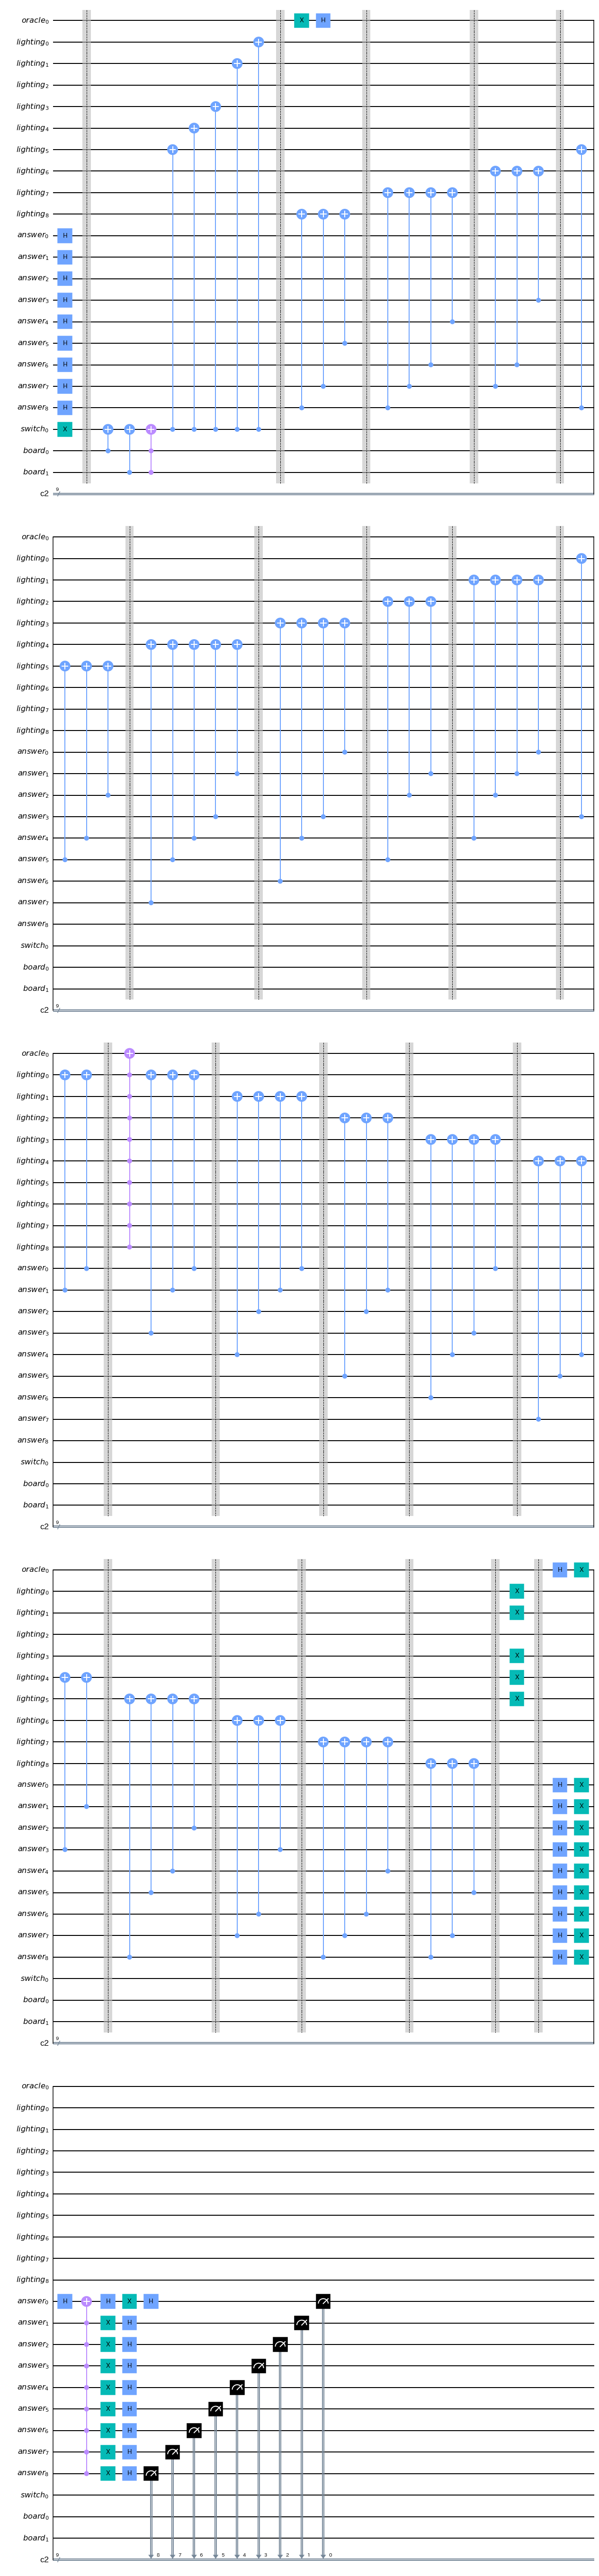

In [8]:
qc = solve_board(0)
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))
qc.draw(output='mpl')

最も確率が高い状態は`110110111`で先ほどと同じ状態が得られました。  
ということで、qRAMを使って問題を埋め込むことができます。

---

## カウンター

push数をカウントするための量子回路は自分で思いつくことができず、[公式からのヒント](https://github.com/qiskit-community/IBMQuantumChallenge2020/blob/main/hints/hint_2b.pdf)記載のカウンターをそのまま使いました。  
(当初は全加算器で0~9を求めるつもりでしたが、ビット数が足りませんでした。)

In [10]:
def counter(qc, flip, auxiliary):
    for i in range(len(flip)):
        qc.mct([flip[i], auxiliary[0], auxiliary[1], auxiliary[2]], auxiliary[3], mode='noancilla')
        qc.mct([flip[i], auxiliary[0], auxiliary[1]], auxiliary[2], mode='noancilla')
        qc.ccx(flip[i], auxiliary[0], auxiliary[1])
        qc.cx(flip[i], auxiliary[0])
        qc.barrier()
        

In [11]:
def inv_counter(qc, flip, auxiliary):
    for i in range(len(flip)):
        qc.cx(flip[len(flip) - 1 - i], auxiliary[0])
        qc.ccx(flip[len(flip) - 1 - i], auxiliary[0], auxiliary[1])
        qc.mct([flip[len(flip) - 1 - i], auxiliary[0], auxiliary[1]], auxiliary[2], mode='noancilla')
        qc.mct([flip[len(flip) - 1 - i], auxiliary[0], auxiliary[1], auxiliary[2]], auxiliary[3], mode='noancilla')
        qc.barrier()
        

これらを使って、3を検出できるか試します。

### 3箇所(1, 2, 5)をpushした場合

1    1024
dtype: int64


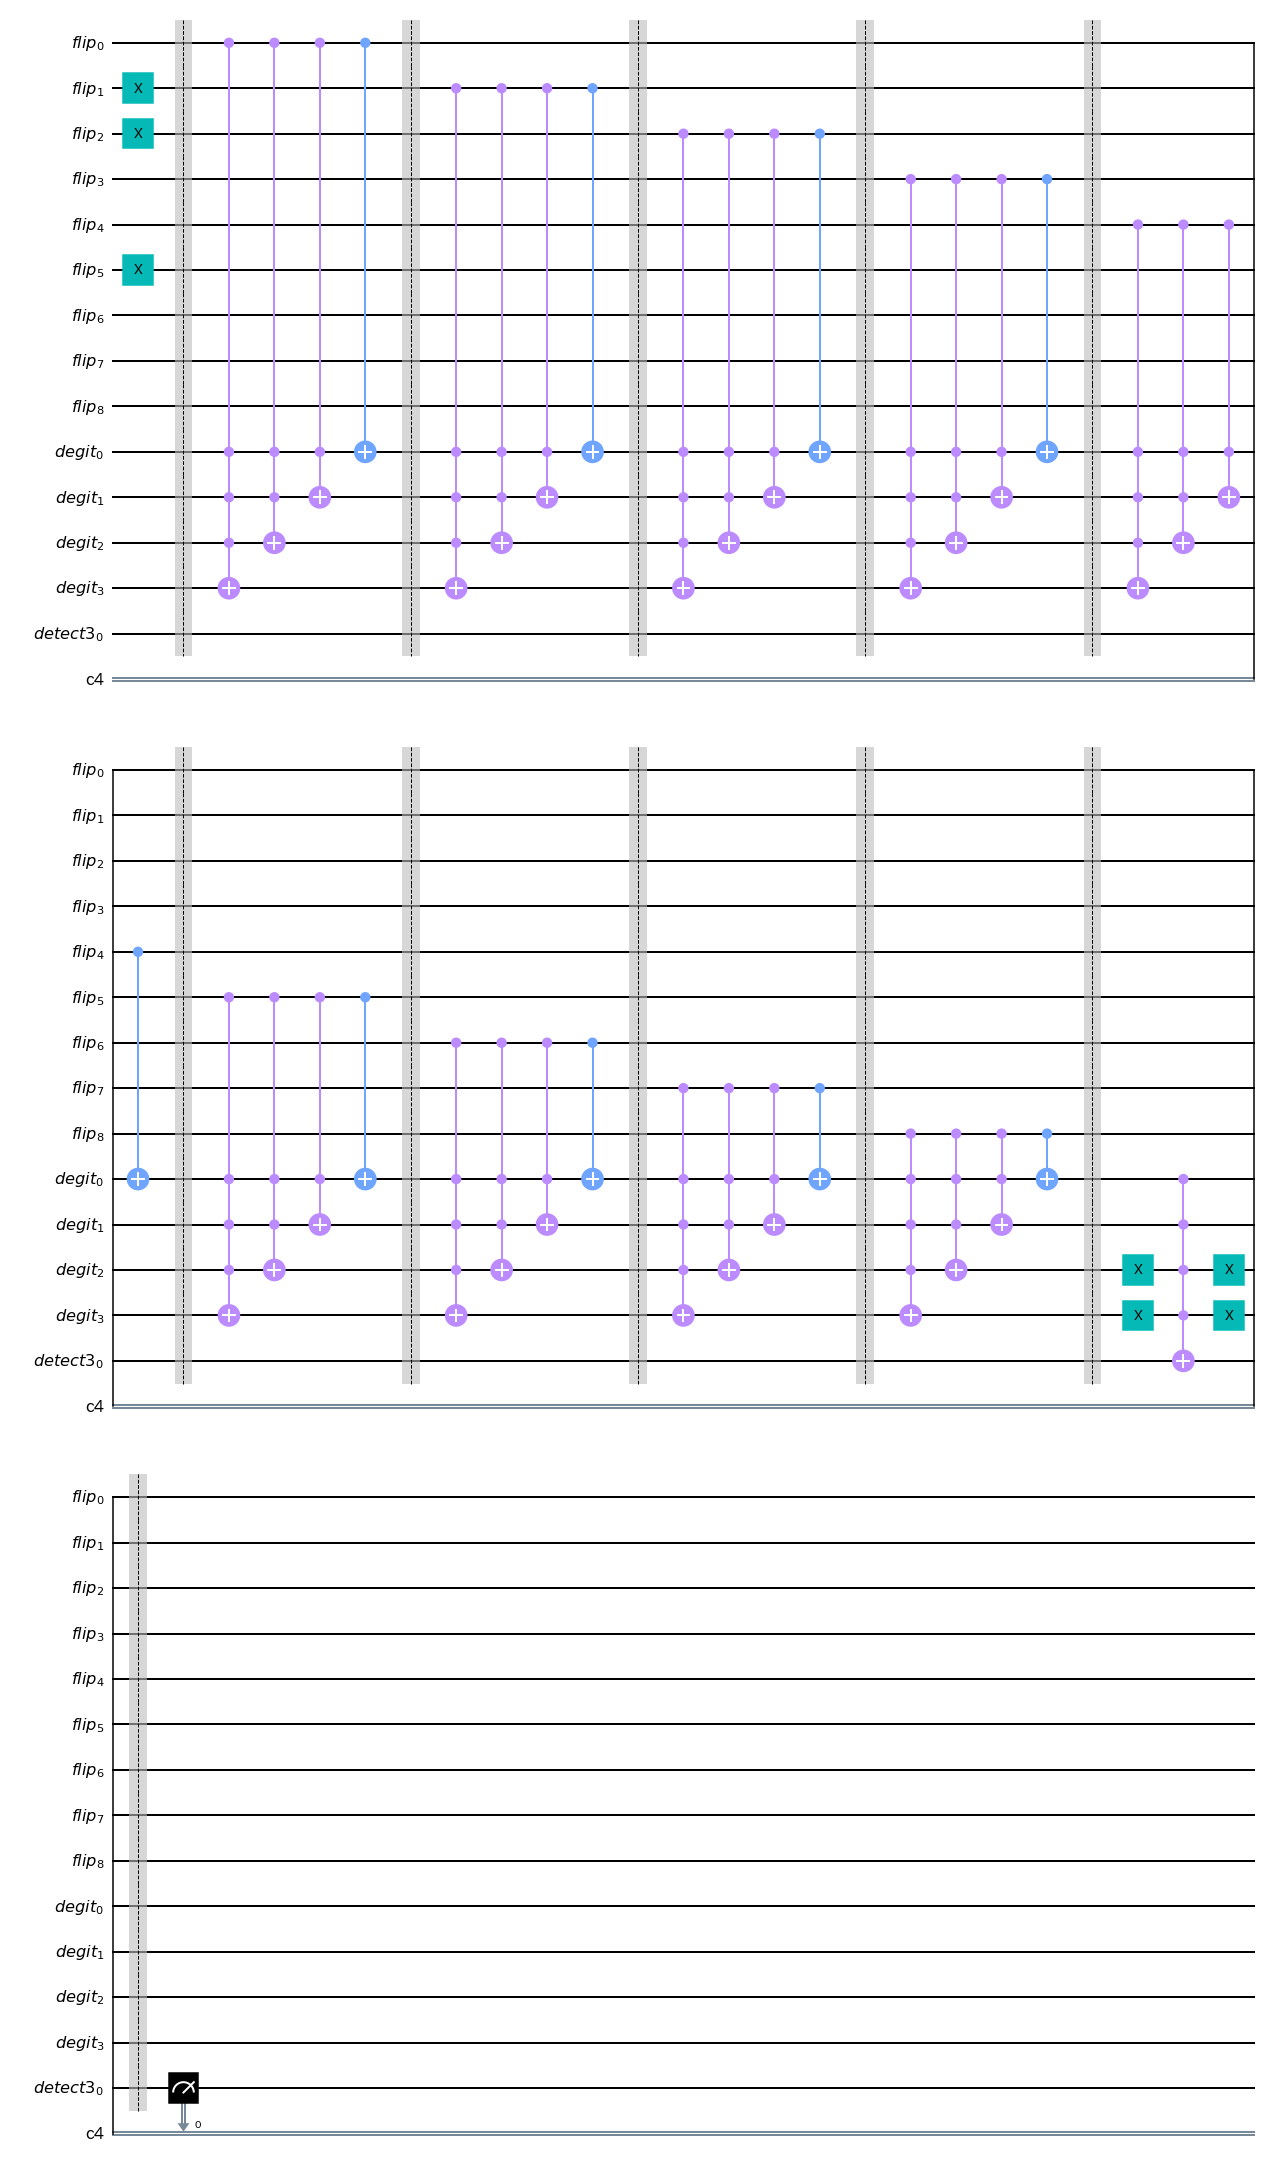

In [12]:
flip = QuantumRegister(9, 'flip')
auxiliary = QuantumRegister(4, 'degit')
detect = QuantumRegister(1, 'detect3')
cr = ClassicalRegister(1)
qc = QuantumCircuit(flip, auxiliary, detect, cr)
qc.x(flip[[1, 2, 5]])
qc.barrier()

counter(qc, flip, auxiliary)

# 3(0011)の場合だけXゲート
qc.x(auxiliary[2:])
qc.mct(auxiliary, detect)
qc.x(auxiliary[2:])
qc.barrier()

qc.measure(detect, cr)

backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

qc.draw(output='mpl')

#### 4か所(1, 2, 3, 5)をpushした場合

0    1024
dtype: int64


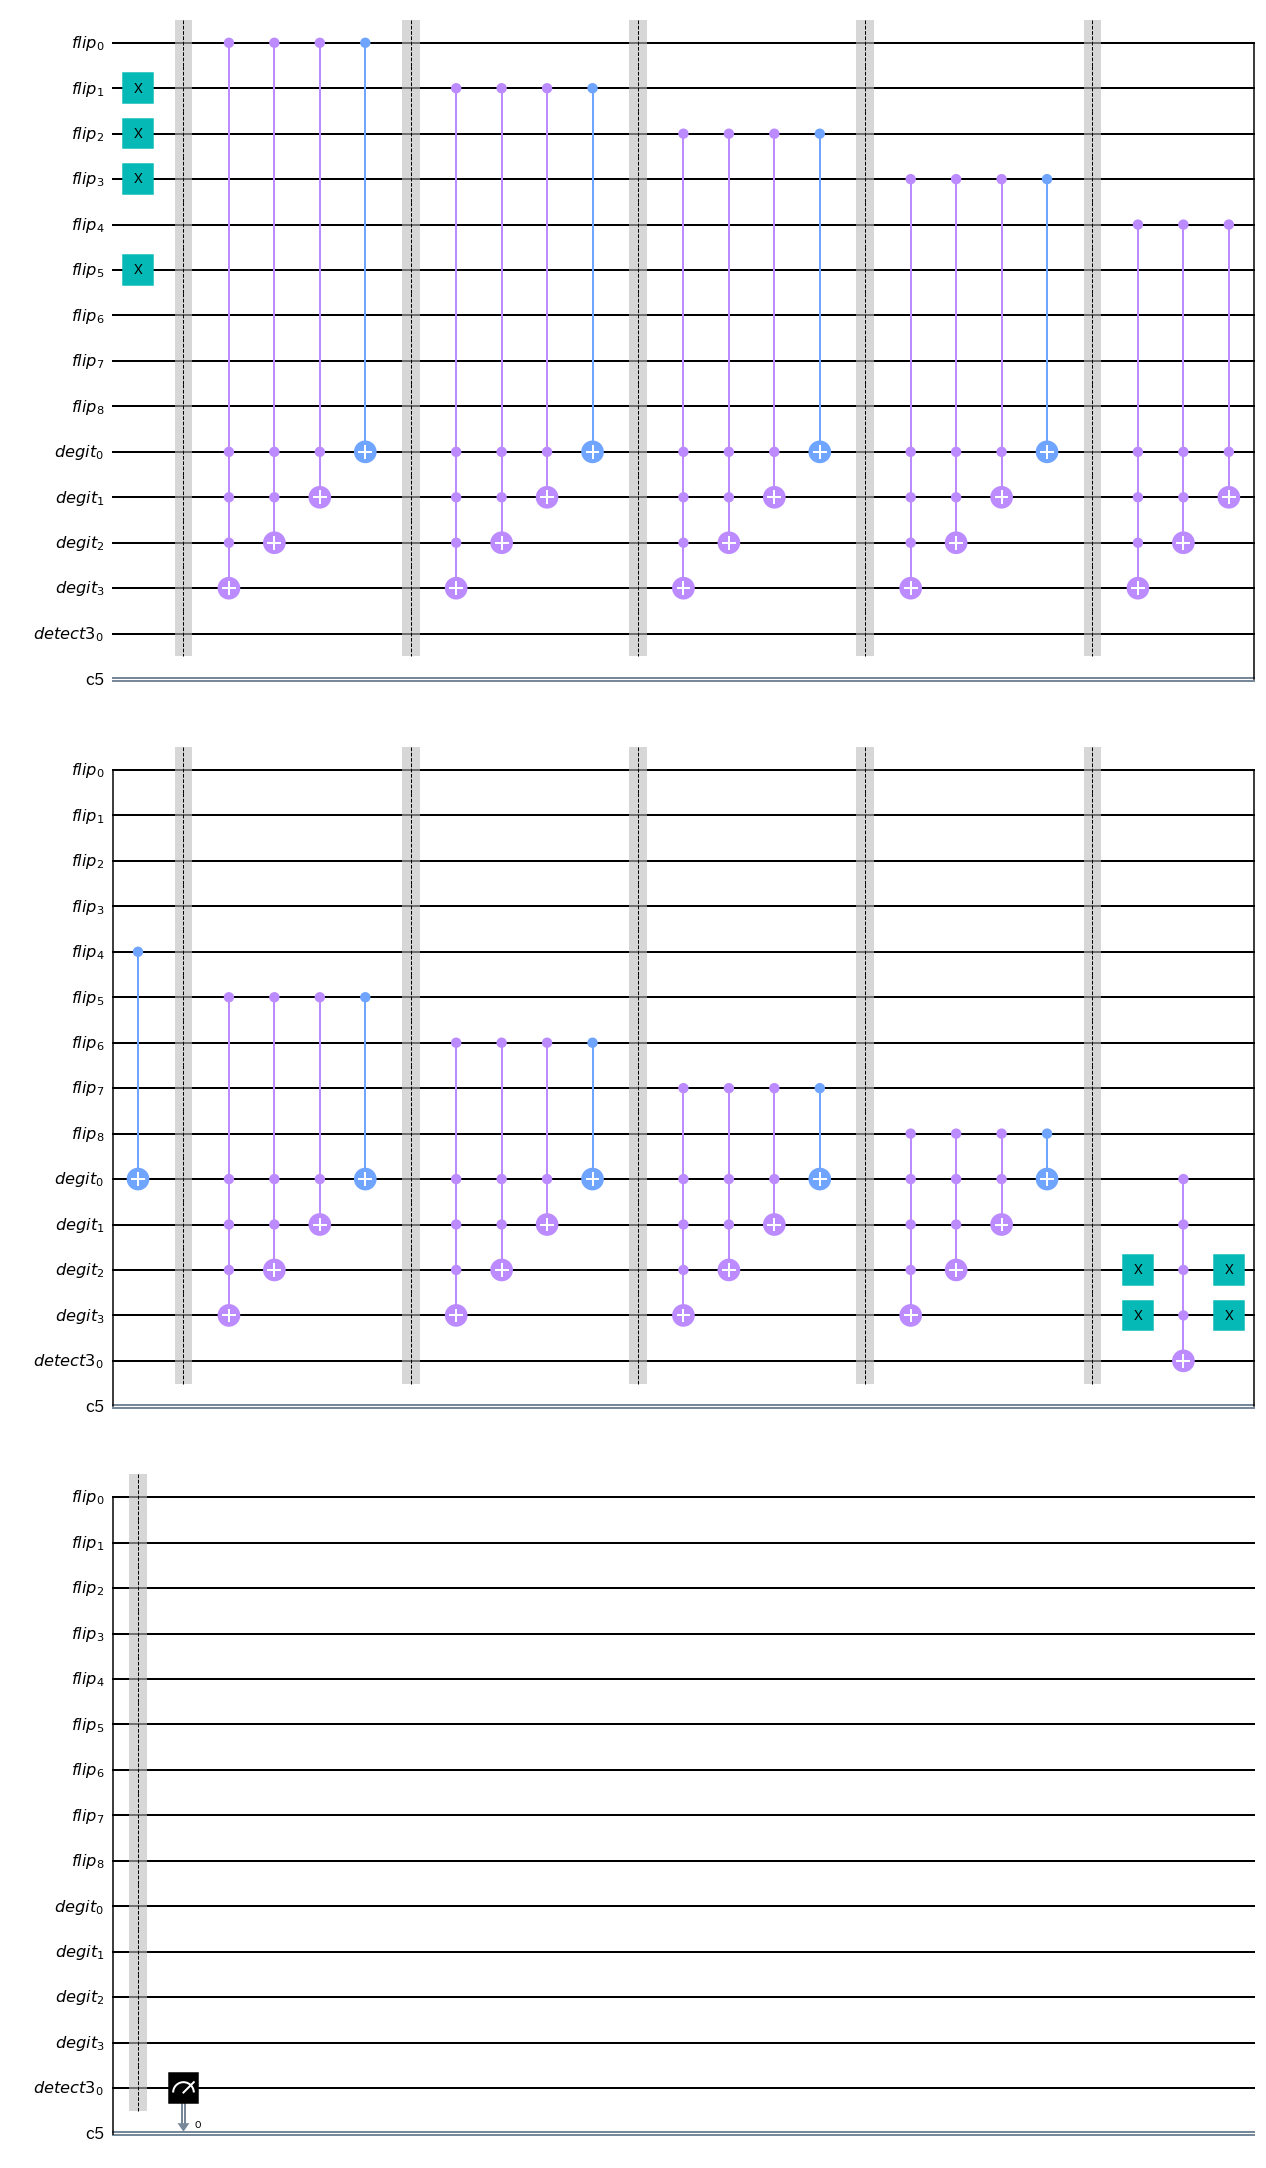

In [13]:
flip = QuantumRegister(9, 'flip')
auxiliary = QuantumRegister(4, 'degit')
detect = QuantumRegister(1, 'detect3')
cr = ClassicalRegister(1)
qc = QuantumCircuit(flip, auxiliary, detect, cr)
qc.x(flip[[1, 2, 3, 5]])
qc.barrier()

counter(qc, flip, auxiliary)

# 3(0011)の場合だけXゲート
qc.x(auxiliary[2:])
qc.mct(auxiliary, detect)
qc.x(auxiliary[2:])
qc.barrier()

qc.measure(detect, cr)

backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

qc.draw(output='mpl')

ということで3回pushした場合のみ`detect3`のビットが反転することが分かりました。  
では外部から「3」を与えずに、面の答えのpush数を数えられるようにします。

---

## boardのpush数を数える

In [68]:
def count_push(num_board):
    lights = lightsout4[0]
    num_lights = len(lights)

    board = QuantumRegister(2, 'borad')
    switch = QuantumRegister(4, 'switch')
    answer = QuantumRegister(num_lights, 'answer')
    lighting = QuantumRegister(num_lights, 'lighting')
    degit = QuantumRegister(4, 'degit')
    oracle = QuantumRegister(1, 'oracle')
    cr = ClassicalRegister(num_lights + len(degit))
    qc = QuantumCircuit(board, switch, answer, lighting, degit, oracle, cr)

    # Initialization
    if num_board == 0:
        pass
    elif num_board == 1:
        qc.x(board[0])
    elif num_board == 2:
        qc.x(board[1])
    elif num_board == 3:
        qc.x(board)
    else:
        raise ValueError('The board no.0 - 3 are supported.')
        
    qc.h(answer)
    qc.barrier()
    
    # No.0: 00のみ
    qc.x(switch[0])
    qc.cx(board[1], switch[0])
    qc.cx(board[0], switch[0])
    qc.ccx(board[0], board[1], switch[0])
    qc.barrier()

    # No.1: 01のみ
    qc.x(board[1])
    qc.ccx(board[0], board[1], switch[1])
    qc.x(board[1])
    qc.barrier()
    
    # No.2: 10のみ
    qc.x(board[0])
    qc.ccx(board[0], board[1], switch[2])
    qc.x(board[0])
    qc.barrier()
    
    # No.3: 11のみ
    qc.ccx(board[0], board[1], switch[3])
    qc.barrier()
    
    # 光っている場所を設定
    for idx_light, lights in enumerate(lightsout4):
        lights_key = str(lights)[1:-1].replace(', ', '')
        for idx, num in enumerate(lights_key):
            if num == '0':
                qc.cx(switch[idx_light], lighting[idx])
        qc.barrier()
    
    # oracle_9q
    qc.x(oracle)
    qc.h(oracle)

    qc.cx(answer[0], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[3], lighting[0])
    qc.barrier()

    qc.cx(answer[0], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[4], lighting[1])
    qc.barrier()

    qc.cx(answer[1], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[5], lighting[2])
    qc.barrier()

    qc.cx(answer[0], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[6], lighting[3])
    qc.barrier()

    qc.cx(answer[1], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[7], lighting[4])
    qc.barrier()

    qc.cx(answer[2], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[8], lighting[5])
    qc.barrier()

    qc.cx(answer[3], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[7], lighting[6])
    qc.barrier()

    qc.cx(answer[4], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[8], lighting[7])
    qc.barrier()

    qc.cx(answer[5], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[8], lighting[8])
    qc.barrier()

    qc.mct(lighting, oracle[0], mode='noancilla') 

    qc.cx(answer[8], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[5], lighting[8])
    qc.barrier()

    qc.cx(answer[8], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[4], lighting[7])
    qc.barrier()

    qc.cx(answer[7], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[3], lighting[6])
    qc.barrier()

    qc.cx(answer[8], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[2], lighting[5])
    qc.barrier()

    qc.cx(answer[7], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[1], lighting[4])
    qc.barrier()

    qc.cx(answer[6], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[0], lighting[3])
    qc.barrier()

    qc.cx(answer[5], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[1], lighting[2])
    qc.barrier()

    qc.cx(answer[4], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[0], lighting[1])
    qc.barrier()

    qc.cx(answer[3], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[0], lighting[0])
    qc.barrier()

    for idx_light, lights in enumerate(lightsout4[::-1]):
        lights_key = str(lights)[1:-1].replace(', ', '')
        for idx, num in enumerate(lights_key[::-1]):
            if num == '0':
                qc.cx(switch[len(switch) - (idx_light + 1)], lighting[len(lighting) - (idx + 1)])
        qc.barrier()

    # diffusion_9q
    qc.h(answer)
    qc.x(answer)
    qc.h(answer[num_lights - 1])
    qc.mct(answer[0:num_lights - 1], answer[num_lights - 1], mode='noancilla')
    qc.h(answer[num_lights - 1])
    qc.x(answer)
    qc.h(answer)

    qc.h(oracle)
    qc.x(oracle)
    
    counter(qc, answer, degit)
    
    qc.measure(answer, cr[:len(answer)])
    qc.measure(degit, cr[len(answer):])

    # Change the endian 
    qc = qc.reverse_bits() 

    return qc

In [15]:
from qiskit.tools.monitor import job_monitor

### 0(00)番の面の場合

Job Status: job has successfully run
1101101111110    17
0011111100110     7
1110110111110     6
0011000110010     6
0000110110010     6
                 ..
0101100111010     1
1101101001010     1
1101100110110     1
1101011111110     1
0111111110001     1
Length: 453, dtype: int64


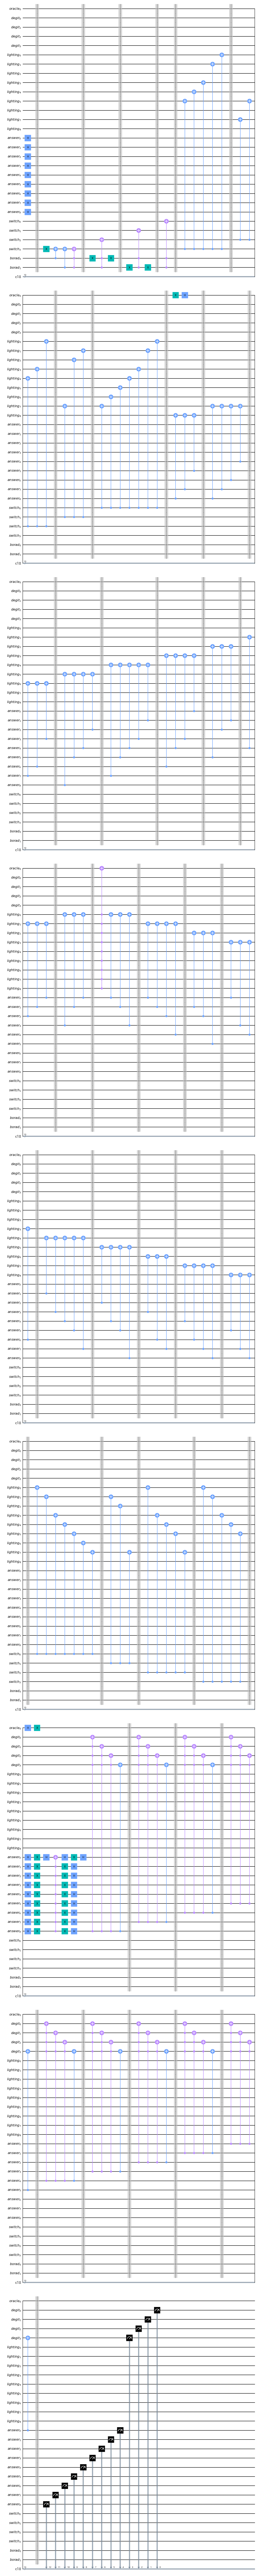

In [37]:
qc = count_push(0)

backend = provider.get_backend('ibmq_qasm_simulator')
shots = 1024
job_exp = execute(qc, backend=backend, shots=shots)
job_monitor(job_exp, interval = 2)

results = job_exp.result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

qc.draw(output='mpl')

最も確率が高い状態は`1101101111110`で、`[正解状態9桁, push数4桁]`と読みます。  
したがって正解状態は`110110111`で, push数は7ですがそれも右から読んで`0111`(左から読んで`1110`)となっており、ちゃんと正解状態のpush回数を数えられています。

### 1(01)番の面の場合

Job Status: job has successfully run
0011100001100    23
1110001101010     6
0010010110010     6
0110101110110     6
0011100100010     5
                 ..
1100011000010     1
1100010111010     1
1100010100010     1
1100010001100     1
0111111110001     1
Length: 456, dtype: int64


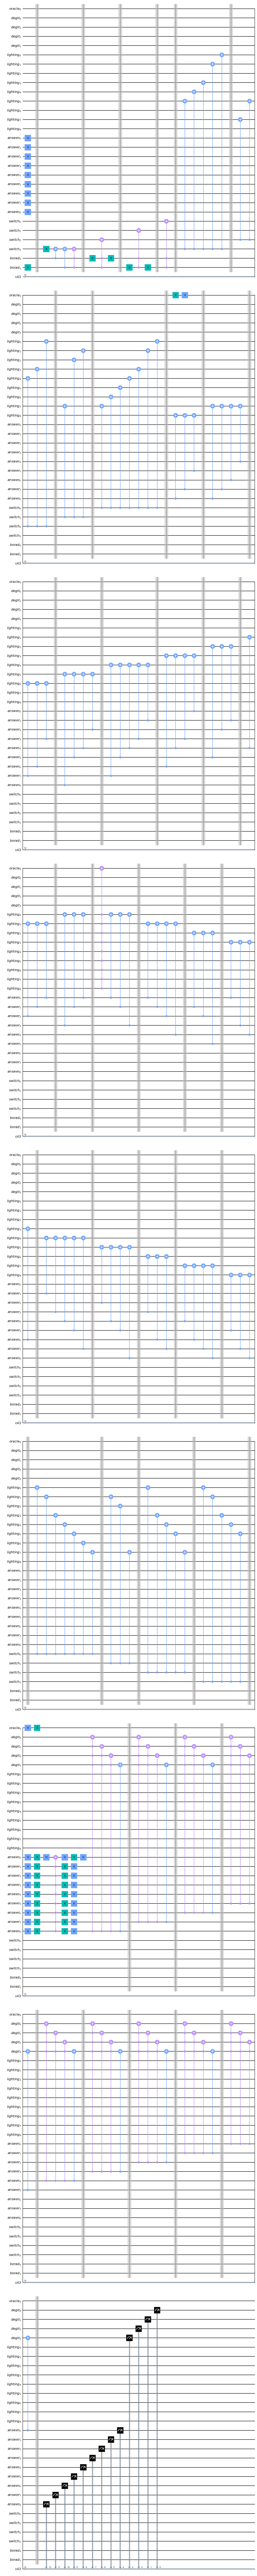

In [79]:
qc = count_push(1)

backend = provider.get_backend('ibmq_qasm_simulator')
shots = 1024
job_exp = execute(qc, backend=backend, shots=shots)
job_monitor(job_exp, interval = 2)

results = job_exp.result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

qc.draw(output='mpl')

最も確率が高い状態は`0011100001100`で、`[正解状態9桁, push数4桁]`と読みます。  
したがって正解状態は`001110000`で, push数は3ですがそれも右から読んで`0011`(左から読んで`1100`)となっており、ちゃんと正解状態のpush回数を数えられています。  
ただ、この時点で正解以外の確率もそれなりにあるということには注意です。

---

## push数3を検出

正解でかつpush数3の状態を検出しましょう。  
(qRAMの表現も少し変えています。)

In [86]:
def _glover(qc, answer, lighting, oracle_sub):
    qc.cx(answer[0], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[3], lighting[0])
    qc.barrier()

    qc.cx(answer[0], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[4], lighting[1])
    qc.barrier()

    qc.cx(answer[1], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[5], lighting[2])
    qc.barrier()

    qc.cx(answer[0], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[6], lighting[3])
    qc.barrier()

    qc.cx(answer[1], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[7], lighting[4])
    qc.barrier()

    qc.cx(answer[2], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[8], lighting[5])
    qc.barrier()

    qc.cx(answer[3], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[7], lighting[6])
    qc.barrier()

    qc.cx(answer[4], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[8], lighting[7])
    qc.barrier()

    qc.cx(answer[5], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[8], lighting[8])
    qc.barrier()
    
    qc.mct(lighting, oracle_sub[0], mode='noancilla') 

    qc.cx(answer[8], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[5], lighting[8])
    qc.barrier()

    qc.cx(answer[8], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[4], lighting[7])
    qc.barrier()

    qc.cx(answer[7], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[3], lighting[6])
    qc.barrier()

    qc.cx(answer[8], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[2], lighting[5])
    qc.barrier()

    qc.cx(answer[7], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[1], lighting[4])
    qc.barrier()

    qc.cx(answer[6], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[0], lighting[3])
    qc.barrier()

    qc.cx(answer[5], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[1], lighting[2])
    qc.barrier()

    qc.cx(answer[4], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[0], lighting[1])
    qc.barrier()

    qc.cx(answer[3], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[0], lighting[0])
    qc.barrier()
                
    # diffusion answers
    qc.h(answer)
    qc.x(answer)
    qc.h(answer[len(answer) - 1])
    qc.mct(answer[0:len(answer) - 1], answer[len(answer) - 1], mode='noancilla')
    qc.h(answer[len(answer) - 1])
    qc.x(answer)
    qc.h(answer)
    qc.barrier()

    
def detect_push3(num_board):
    lights = lightsout4[0]
    num_lights = len(lights)

    board = QuantumRegister(2, 'board')
    answer = QuantumRegister(num_lights, 'answer')
    lighting = QuantumRegister(num_lights, 'lighting')
    degit = QuantumRegister(4, 'degit')
    detect3 = QuantumRegister(1, 'detect3')
    oracle_sub = QuantumRegister(1, 'oracle_sub')
    cr = ClassicalRegister(1 + len(answer))
    qc = QuantumCircuit(board, answer, lighting, degit, detect3, oracle_sub, cr)

    # Initialization
    if num_board == 0:
        pass
    elif num_board == 1:
        qc.x(board[0])
    elif num_board == 2:
        qc.x(board[1])
    elif num_board == 3:
        qc.x(board)
    else:
        raise ValueError('The board no.0 - 3 are supported.')        
    qc.h(answer)
    qc.barrier()
    
    # 光っている場所を設定
    for idx_light, lights in enumerate(lightsout4):
        lights_key = str(lights)[1:-1].replace(', ', '')
        if idx_light == 0:
            qc.x(board)
            for idx, num in enumerate(lights_key):
                if num == '0':
                    # No.0: 00のみ
                    qc.ccx(board[0], board[1], lighting[idx])
            qc.x(board)
            qc.barrier()
            
        elif idx_light == 1:                
            qc.x(board[1])
            for idx, num in enumerate(lights_key):
                if num == '0':
                    # No.1: 01のみ
                    qc.ccx(board[0], board[1], lighting[idx])
            qc.x(board[1])
            qc.barrier()
                    
        elif idx_light == 2:                
            qc.x(board[0])
            for idx, num in enumerate(lights_key):
                if num == '0':
                    # No.2: 10のみ
                    qc.ccx(board[0], board[1], lighting[idx])
            qc.x(board[0])
            qc.barrier()
                    
        else:                
            for idx, num in enumerate(lights_key):
                if num == '0':
                    # No.3: 11のみ
                    qc.ccx(board[0], board[1], lighting[idx])
            qc.barrier()
    
    # oracle_9q
    qc.x(oracle_sub)
    qc.h(oracle_sub)
    qc.barrier()

    _glover(qc, answer, lighting, oracle_sub)    
    
    qc.h(oracle_sub)
    qc.x(oracle_sub)
    qc.barrier()
    
    # mainのoracle
    counter(qc, answer, degit)    
    qc.x(degit[2:])
    qc.mct([
        degit[0], 
        degit[1], 
        degit[2], 
        degit[3], 
    ], detect3, mode='noancilla')     
    qc.x(degit[2:])    
    qc.barrier()
    
    qc.measure(detect3, cr[0])
    qc.measure(answer, cr[1:])

    # Change the endian 
    qc = qc.reverse_bits() 

    return qc

### 0(00)番の面の場合(not 3 push)

Job Status: job has successfully run
0110110111    11
0111101111     7
0000100100     6
1111000000     6
0101010110     6
              ..
1100100010     1
1100100001     1
0110110001     1
1100001100     1
0000000000     1
Length: 419, dtype: int64


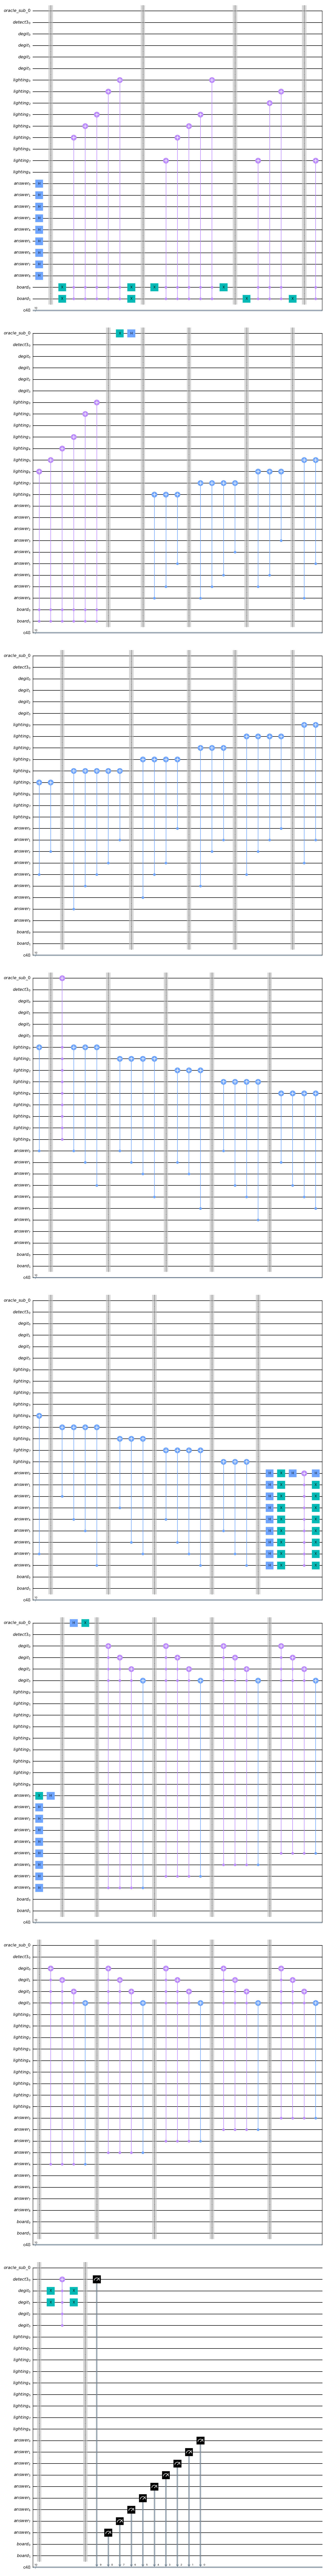

In [87]:
qc = detect_push3(0)

backend = provider.get_backend('ibmq_qasm_simulator')
shots = 1024
job_exp = execute(qc, backend=backend, shots=shots)
job_monitor(job_exp, interval = 2)

results = job_exp.result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

qc.draw(output='mpl')

最も確率が高い状態は`0110110111`で、`[push数3の検出フラグ, 正解状態]`と読みますが、  
この面(0)の正解状態は`110110111`で、push数は7で確かにpush数3の検出フラグは`0`になっています。

### 1(01)番の面の場合(3 push)

Job Status: job has successfully run
1001110000    21
0110011011     7
0100111100     6
0111100110     6
0010011001     6
              ..
1000001011     1
1010011000     1
0001111010     1
1010001100     1
0111111111     1
Length: 434, dtype: int64


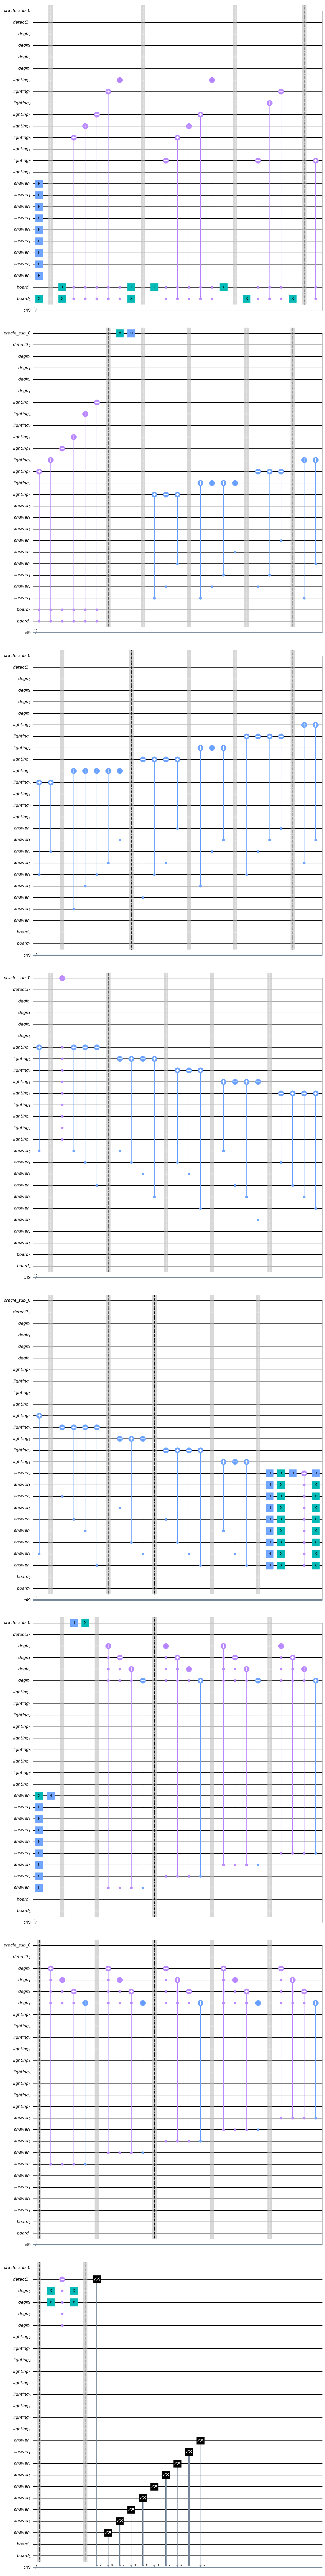

In [88]:
qc = detect_push3(1)

backend = provider.get_backend('ibmq_qasm_simulator')
shots = 1024
job_exp = execute(qc, backend=backend, shots=shots)
job_monitor(job_exp, interval = 2)

results = job_exp.result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

qc.draw(output='mpl')

最も確率が高い状態は`1001110000`で、`[push数3の検出フラグ, 正解状態]`と読みますが、  
この面(0)の正解状態は`001110000`で、push数は3で確かにpush数3の検出フラグは`1`になっています。  

ここまでで、個別の面の状態についてpush数が3かそうでないかを検出できるようになりました。  
**面0(00)はほぼ**`110110111`**という正解状態を向いたベクトルを持っていて、このpush数は7であり3ではありません。**  
という状態を$|00> \bigotimes |110110111> \bigotimes |1>$と表せそうです。(厳密には$|110110111>$の部分は他の状態との重ね合わせですが、ほぼ0と見なします。)  
そしてこの状態は位相を反転する対象ではありません。  

一方で
**面1(01)はほぼ**`001110000`**という正解状態を向いたベクトルを持っていて、このpush数は3です。**  
という状態を$|01> \bigotimes |001110000> \bigotimes |1>$と表せそうです。(厳密には$|001110000>$の部分は他の状態との重ね合わせですが、ほぼ0と見なします。)  
そしてこの状態は位相を反転する対象であり、

$$
    |01> \bigotimes |001110000> \bigotimes |1> \longrightarrow - |01> \bigotimes |001110000> \bigotimes |1>
$$

とできそうです。  
(細かい数学について、誤り有ればご指摘お願いします。)   

もう一歩踏み込むと、面状態$|00>, |01>, |10>, |11>$の4状態で条件を満たして確率振幅の位相を反転できるのは$|01>$ということで、ここまで含めてオラクルとなります。  
あとは形式的にオラクルのここまでの過程を逆順に戻っていき、最後にDiffusion回路で増幅してあげましょう！

---
## 提出した解答

In [93]:
def _glover(qc, answer, lighting, oracle_sub):
    qc.cx(answer[0], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[3], lighting[0])
    qc.barrier()

    qc.cx(answer[0], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[4], lighting[1])
    qc.barrier()

    qc.cx(answer[1], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[5], lighting[2])
    qc.barrier()

    qc.cx(answer[0], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[6], lighting[3])
    qc.barrier()

    qc.cx(answer[1], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[7], lighting[4])
    qc.barrier()

    qc.cx(answer[2], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[8], lighting[5])
    qc.barrier()

    qc.cx(answer[3], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[7], lighting[6])
    qc.barrier()

    qc.cx(answer[4], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[8], lighting[7])
    qc.barrier()

    qc.cx(answer[5], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[8], lighting[8])
    qc.barrier()
    
    qc.mct(lighting, oracle_sub[0], mode='noancilla') 

    qc.cx(answer[8], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[5], lighting[8])
    qc.barrier()

    qc.cx(answer[8], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[4], lighting[7])
    qc.barrier()

    qc.cx(answer[7], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[3], lighting[6])
    qc.barrier()

    qc.cx(answer[8], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[2], lighting[5])
    qc.barrier()

    qc.cx(answer[7], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[1], lighting[4])
    qc.barrier()

    qc.cx(answer[6], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[0], lighting[3])
    qc.barrier()

    qc.cx(answer[5], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[1], lighting[2])
    qc.barrier()

    qc.cx(answer[4], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[0], lighting[1])
    qc.barrier()

    qc.cx(answer[3], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[0], lighting[0])
    qc.barrier()
                
    # diffusion answers
    qc.h(answer)
    qc.x(answer)
    qc.h(answer[len(answer) - 1])
    qc.mct(answer[0:len(answer) - 1], answer[len(answer) - 1], mode='noancilla')
    qc.h(answer[len(answer) - 1])
    qc.x(answer)
    qc.h(answer)
    qc.barrier()

def _inv_glover(qc, answer, lighting, oracle_sub):
    qc.h(answer)
    qc.x(answer)
    qc.h(answer[len(answer) - 1])
    qc.mct(answer[0:len(answer) - 1], answer[len(answer) - 1], mode='noancilla')
    qc.h(answer[len(answer) - 1])
    qc.x(answer)
    qc.h(answer)
    qc.barrier()

    qc.x(oracle_sub)
    qc.h(oracle_sub)
    qc.barrier()

    qc.cx(answer[0], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[3], lighting[0])
    qc.barrier()

    qc.cx(answer[0], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[4], lighting[1])
    qc.barrier()

    qc.cx(answer[1], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[5], lighting[2])
    qc.barrier()

    qc.cx(answer[0], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[6], lighting[3])
    qc.barrier()

    qc.cx(answer[1], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[7], lighting[4])
    qc.barrier()

    qc.cx(answer[2], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[8], lighting[5])
    qc.barrier()

    qc.cx(answer[3], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[7], lighting[6])
    qc.barrier()

    qc.cx(answer[4], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[8], lighting[7])
    qc.barrier()

    qc.cx(answer[5], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[8], lighting[8])
    qc.barrier()
    
    qc.mct(lighting, oracle_sub[0], mode='noancilla') 

    qc.cx(answer[8], lighting[8])
    qc.cx(answer[7], lighting[8])
    qc.cx(answer[5], lighting[8])
    qc.barrier()

    qc.cx(answer[8], lighting[7])
    qc.cx(answer[7], lighting[7])
    qc.cx(answer[6], lighting[7])
    qc.cx(answer[4], lighting[7])
    qc.barrier()

    qc.cx(answer[7], lighting[6])
    qc.cx(answer[6], lighting[6])
    qc.cx(answer[3], lighting[6])
    qc.barrier()

    qc.cx(answer[8], lighting[5])
    qc.cx(answer[5], lighting[5])
    qc.cx(answer[4], lighting[5])
    qc.cx(answer[2], lighting[5])
    qc.barrier()

    qc.cx(answer[7], lighting[4])
    qc.cx(answer[5], lighting[4])
    qc.cx(answer[4], lighting[4])
    qc.cx(answer[3], lighting[4])
    qc.cx(answer[1], lighting[4])
    qc.barrier()

    qc.cx(answer[6], lighting[3])
    qc.cx(answer[4], lighting[3])
    qc.cx(answer[3], lighting[3])
    qc.cx(answer[0], lighting[3])
    qc.barrier()

    qc.cx(answer[5], lighting[2])
    qc.cx(answer[2], lighting[2])
    qc.cx(answer[1], lighting[2])
    qc.barrier()

    qc.cx(answer[4], lighting[1])
    qc.cx(answer[2], lighting[1])
    qc.cx(answer[1], lighting[1])
    qc.cx(answer[0], lighting[1])
    qc.barrier()

    qc.cx(answer[3], lighting[0])
    qc.cx(answer[1], lighting[0])
    qc.cx(answer[0], lighting[0])
    qc.barrier()
    
def week2b_ans_func(lightout4):
    lights = lightout4[0]
    num_lights = len(lights)

    board = QuantumRegister(2, 'board')
    answer = QuantumRegister(num_lights, 'answer')
    lighting = QuantumRegister(num_lights, 'lighting')
    degit = QuantumRegister(4, 'degit')
    oracle = QuantumRegister(1, 'oracle')
    oracle_sub = QuantumRegister(1, 'oracle_sub')
    cr = ClassicalRegister(len(board))
    qc = QuantumCircuit(board, answer, lighting, degit, oracle, oracle_sub, cr)

    # Initialization
    qc.h(board)
        
    qc.h(answer)
    qc.barrier()
    
    # 光っている場所を設定
    for idx_light, lights in enumerate(lightout4):
        lights_key = str(lights)[1:-1].replace(', ', '')
        if idx_light == 0:
            qc.x(board)
            for idx, num in enumerate(lights_key):
                if num == '0':
                    # No.0: 00のみ
                    qc.ccx(board[0], board[1], lighting[idx])
            qc.x(board)
            qc.barrier()
            
        elif idx_light == 1:                
            qc.x(board[0])
            for idx, num in enumerate(lights_key):
                if num == '0':
                    # No.1: 01のみ
                    qc.ccx(board[0], board[1], lighting[idx])
            qc.x(board[0])
            qc.barrier()
                    
        elif idx_light == 2:                
            qc.x(board[1])
            for idx, num in enumerate(lights_key):
                if num == '0':
                    # No.2: 10のみ
                    qc.ccx(board[0], board[1], lighting[idx])
            qc.x(board[1])
            qc.barrier()
                    
        else:                
            for idx, num in enumerate(lights_key):
                if num == '0':
                    # No.3: 11のみ
                    qc.ccx(board[0], board[1], lighting[idx])
            qc.barrier()
    
    # oracle_9q
    qc.x(oracle)
    qc.h(oracle)
    qc.barrier()
    
    qc.x(oracle_sub)
    qc.h(oracle_sub)
    qc.barrier()

    _glover(qc, answer, lighting, oracle_sub)    
    
    qc.h(oracle_sub)
    qc.x(oracle_sub)
    qc.barrier()
    
    # mainのoracle
    counter(qc, answer, degit)    
    qc.x(degit[2:])
    qc.mct([
        degit[0], 
        degit[1], 
        degit[2], 
        degit[3], 
    ], oracle[0], mode='noancilla')     
    qc.x(degit[2:])    
    qc.barrier()
    inv_counter(qc, answer, degit) 
    
    # answerの探索を巻き戻す
    # diffusion answers
    qc.x(oracle_sub)
    qc.h(oracle_sub)
    qc.barrier()
    
    _inv_glover(qc, answer, lighting, oracle_sub)
    
    qc.h(answer)
    qc.barrier()

    # 光っている場所を設定
    for idx_light, lights in enumerate(lightout4[::-1]):
        lights_key = str(lights)[1:-1].replace(', ', '')
        if len(lightout4) - 1 - idx_light == 0:
            qc.x(board)
            for idx, num in enumerate(lights_key[::-1]):
                if num == '0':
                    # No.0: 00のみ
                    qc.ccx(board[0], board[1], lighting[len(lights_key) - 1 - idx])
            qc.x(board)
            qc.barrier()
            
        elif len(lightout4) - 1 - idx_light == 1:                
            qc.x(board[0])
            for idx, num in enumerate(lights_key[::-1]):
                if num == '0':
                    # No.1: 01のみ
                    qc.ccx(board[0], board[1], lighting[len(lights_key) - 1 - idx])
            qc.x(board[0])
            qc.barrier()
                    
        elif len(lightout4) - 1 - idx_light == 2:                
            qc.x(board[1])
            for idx, num in enumerate(lights_key[::-1]):
                if num == '0':
                    # No.2: 10のみ
                    qc.ccx(board[0], board[1], lighting[len(lights_key) - 1 - idx])
            qc.x(board[1])
            qc.barrier()
                    
        else:                
            for idx, num in enumerate(lights_key[::-1]):
                if num == '0':
                    # No.3: 11のみ
                    qc.ccx(board[0], board[1], lighting[len(lights_key) - 1 - idx])
            qc.barrier()
                
    # diffusion_9q
    qc.h(board)
    qc.x(board)
    qc.h(board[len(board) - 1])
    qc.mct(board[0:len(board) - 1], board[len(board) - 1], mode='noancilla')
    qc.h(board[len(board) - 1])
    qc.x(board)
    qc.h(board)

    qc.h(oracle)
    qc.x(oracle)
    
    qc.measure(board, cr)

    # Change the endian 
    qc = qc.reverse_bits() 

    return qc

Job Status: job has successfully run
01    2137
10    2056
00    2023
11    1976
dtype: int64


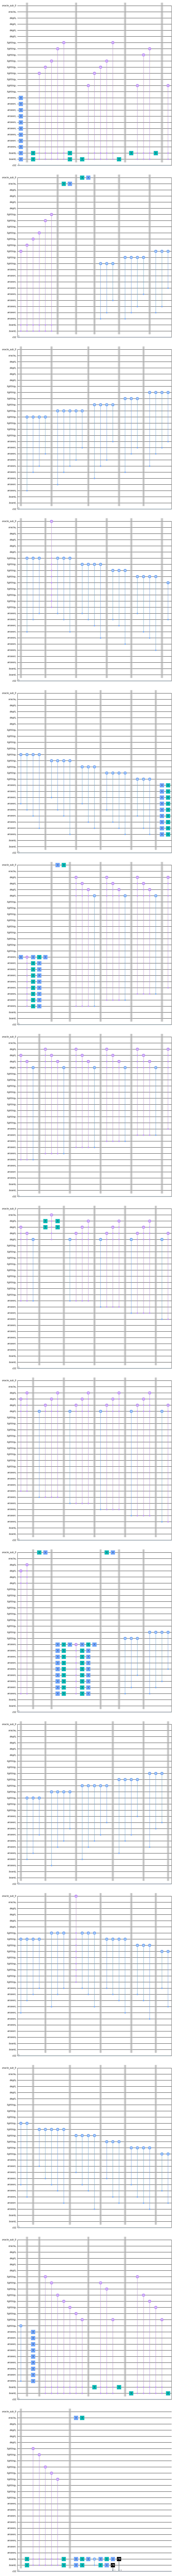

In [94]:
qc = week2b_ans_func(lightsout4)

backend = provider.get_backend('ibmq_qasm_simulator')
shots = 8192
job_exp = execute(qc, backend=backend, shots=shots)
job_monitor(job_exp, interval = 2)

results = job_exp.result()
count = results.get_counts()
sr_count = pd.Series(count)
print(sr_count.sort_values(ascending=False))

qc.draw(output='mpl')

### 解答の検証

In [106]:
# Submission code
from qc_grader import prepare_ex2b, grade_ex2b, submit_ex2b

# Execute your circuit with following prepare_ex2b() function.
# The prepare_ex2b() function works like the execute() function with only QuantumCircuit as an argument.
job  =  prepare_ex2b(week2b_ans_func)

result = job.result()
count = result.get_counts()
original_problem_set_counts = count[0]

original_problem_set_counts
# The bit string with the highest number of observations is treated as the solution.

Running week2b_ans_func...
Computing cost...
Starting experiments. Please wait...
You may monitor the job (id: 5fc26783176371001a2204e7) status and proceed to grading when it successfully completes.


{'00': 1988, '01': 2040, '10': 2025, '11': 1947}

In [107]:
# Check your answer by executing following code.
# The quantum cost of the QuantumCircuit is obtained as the score. The quantum cost is related to rank only in the third week.
grade_ex2b(job)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 69641.
Feel free to submit your answer.


### 解答の提出

In [108]:
# Submit your results by executing following code. You can submit as many times as you like during the period. 
submit_ex2b(job)

Submitting your answer. Please wait...

Success 🎉! Your answer has been submitted.
There seems to be huge "noise clusters" interfering with Dr. Ryoko’s device. Can you please help?
